In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)

In [2]:
# read in pickled DFs generated by query_dfs.py

df_orders = pd.read_pickle("./pickle/df_orders.pickle")
df_train = pd.read_pickle("./pickle/df_train.pickle")
df_prior = pd.read_pickle("./pickle/df_prior.pickle")
df_prod_detail = pd.read_pickle("./pickle/df_prod_detail.pickle")

In [3]:
# read in pickled feature DF generated by feature_engineering_1.ipynb
X = pd.read_pickle("./pickle/X_15.pickle")

In [4]:
X.sample(2)

,product_id,user_id,num_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,user_avg_spacing,user_avg_time,order_hour_of_day_avg,days_since_prior_order_avg
4291956,30391,31125,12,"[24852, 6046, 41540, 34668, 47766, 40706, 3952...",0,"[24852, 6046, 34668, 47766, 41540, 40706, 3039...",1,80392,0.697221,8.590668,11.00000,6.0,15,12.401186,7.909820
3452985,5876,185692,2,"[5161, 21376, 49235, 5450, 24852, 939, 38200, ...",0,"[28745, 25138, 37646, 44632, 26790, 27958, 516...",0,87746,0.689900,8.064014,12.87931,3.0,13,11.060241,6.638736


### Picking up where we left off...

**More. Features.**

* `streak`: how many times in a row has this user ordered this item?
    * this feature is very computationally expensive to add
    * implemented multiprocessing to complete in ~5 minutes. 
    * see `add_streaks.py` for details
        * partially borrowed from 
    


In [17]:
df_orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [18]:
df_prior.sample()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart,in_cart
11844070,2751134,48287,4,1,26299,prior,9,0,8,13.0,"[11777, 21137, 25753, 48287, 45504, 19068, 359...",1


In [5]:
df_streaks = pd.read_csv("../data/order_streaks.csv")
df_streaks.rename(columns={"order_streak": "streak"}, inplace=True)
df_streaks.head(3)

,user_id,product_id,streak
0,1,196,5.0
1,1,12427,5.0
2,1,10258,5.0


Negative streaks indicate the number of weeks since the user last ordered the given product.

In [6]:
X = X.merge(df_streaks, how='left', on=['user_id', 'product_id'])

In [7]:
(X[['product_id', 'user_id', 'num_orders', 'streak']]
     .sample(10))

,product_id,user_id,num_orders,streak
5518362,15495,187800,11,NaN
2704607,42189,72957,1,NaN
3303049,43583,90721,1,NaN
4913596,42846,15528,1,NaN
4695910,651,117837,2,2.0
6430113,47366,179797,1,NaN
4655760,77,164563,1,-3.0
189887,14394,137340,1,NaN
4913783,37103,29738,1,-1.0
7044288,8475,33524,2,NaN


(array([510435., 629405., 804176., 968287.,      0., 982615., 189233.,
         83041.,  39380.,  64719.]),
 array([-4. , -3.1, -2.2, -1.3, -0.4,  0.5,  1.4,  2.3,  3.2,  4.1,  5. ]),
 <BarContainer object of 10 artists>)

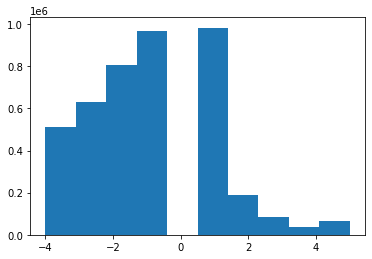

In [8]:
import matplotlib.pyplot as plt
plt.hist(X.streak)

In [9]:
X.streak.value_counts().sort_index()

-4.0    510435
-3.0    629405
-2.0    804176
-1.0    968287
 1.0    982615
 2.0    189233
 3.0     83041
 4.0     39380
 5.0     64719
Name: streak, dtype: int64

Awesome! Now we have an `order_streak` column. But if the user has never purchased the given item in the past, the resulting value is `NaN`. Since we have negative streaks that may help our model, we can't replace the `NaNs` with zeros.

Instead, let's consider this a categorical variable. Let's assign a value to the NaNs and then use pd.get_dummies to split the results.

In [10]:
mask = X.streak == np.NaN
X[mask].shape

(0, 16)

In [11]:
X['streak'] = X.streak.astype(str)
X['streak'] = X['streak'].fillna(value='NA')
X

,product_id,user_id,num_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,user_avg_spacing,user_avg_time,order_hour_of_day_avg,days_since_prior_order_avg,streak
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,12.689189,10.400000,-2.0
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,12.689189,10.400000,nan
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,12.689189,10.400000,nan
3,3265,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,5270,0.586338,6.285958,4.625,1.0,12,12.689189,10.400000,nan
4,4913,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,952,0.385504,5.534664,4.625,1.0,12,12.689189,10.400000,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,44857,2625,3,"[44479, 5657, 32566, 18362, 30759, 36277]",0,"[1716, 44857]",1,72,0.777778,7.027778,2.000,30.0,8,16.000000,30.000000,3.0
8474657,46289,2625,1,"[44479, 5657, 32566, 18362, 30759, 36277]",0,"[1716, 44857]",0,19,0.157895,6.684211,2.000,30.0,8,16.000000,30.000000,-1.0
8474658,42387,11534,12,[42387],1,[42387],1,319,0.746082,7.943574,1.000,7.0,12,10.250000,6.181818,5.0
8474659,49070,31628,5,"[33000, 45608, 37496, 39441, 49070]",1,[49070],1,190,0.484211,9.189474,1.000,30.0,13,13.600000,4.000000,5.0


In [12]:
dummies = pd.get_dummies(X.streak, prefix='streak', drop_first=True)
dummies.head(3)

,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1


In [13]:
dumb_names = list(dummies.columns)
X[dumb_names] = pd.get_dummies(X.streak, prefix='streak', drop_first=True)
X.drop(columns='streak', inplace=True)
X.head(3)

,product_id,user_id,num_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,user_avg_spacing,user_avg_time,order_hour_of_day_avg,days_since_prior_order_avg,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,12.689189,10.4,1,0,0,0,0,0,0,0,0
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,12.689189,10.4,0,0,0,0,0,0,0,0,1
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,12.689189,10.4,0,0,0,0,0,0,0,0,1


In [14]:
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_tr, X_te, y_tr, y_te = split_users(X)

lr = LogisticRegression(solver='lbfgs', max_iter=200)
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

Actual Test Size: 0.2001


0.12116890856461775

In [15]:
X.shape

(8474661, 24)

### More. Features.

* `user_last3_num_purchases`: how many times did the user purchase the product in their last 3 orders?

* `user_last5_num_purchases`: how many times did the user purchase the product in their last 5 orders?



In [43]:
mask = df_orders.eval_set == 'prior'
last_five = df_orders[mask]

last_five = last_five.groupby("user_id").tail(5)
last_five.groupby("order_id")
last_five.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [44]:
cols = ["order_id", "product_id", "in_cart", "reordered"]

last_five = last_five.merge(df_prior[cols], on='order_id')
last_five.head(5)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,in_cart,reordered
0,3367565,1,prior,6,2,7,19.0,196,1,1
1,3367565,1,prior,6,2,7,19.0,12427,1,1
2,3367565,1,prior,6,2,7,19.0,10258,1,1
3,3367565,1,prior,6,2,7,19.0,25133,1,1
4,550135,1,prior,7,1,9,20.0,196,1,1


In [45]:
stat_cols = ["user_id", "product_id", "order_number", "in_cart"]
last_five_2 = (last_five[stat_cols]
             .groupby(["user_id", "product_id"], as_index = False)
             .agg({"in_cart": 'sum'}))

last_five_2.head(30)

,user_id,product_id,in_cart
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
5,1,35951,1
6,1,38928,1
7,1,39657,1
8,1,46149,3
9,1,49235,2


For later...make sure the above worked!

In [47]:
mask = (last_five.user_id == 1) & (last_five.product_id == 13032)
last_five[mask].head(30)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,in_cart,reordered
8,550135,1,prior,7,1,9,20.0,13032,1,1
28,2550362,1,prior,10,4,8,30.0,13032,1,1
